#   FileName: setupData.py
##  Author: Toluwanimi Odemuyiwa
### Date: May 2020
### Description: This sets up the data for the volume rendering process. Mainly it does the following:
            1. loads in volumetric data
            2. determines the gradient values at each voxel/data point using a nearest voxel approach
### Implementation notes:
            1. Gradient values take advantage of the GPU by programming in Pythonic CUDA (using the numba library)

In [66]:
##All the imports
import numba
from numba import cuda

#from ipynb.fs.full.readRaw import readVolume
import json
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from sklearn.cluster import AffinityPropagation 
from sklearn import metrics 

import timeit

In [67]:
def ParseJSON(fname):
    contents = dict()
    # Opening JSON file -- used this as reference: https://www.geeksforgeeks.org/convert-json-to-dictionary-in-python/
    with open(fname) as json_file: 
        contents = json.load(json_file) 

        # Print the type of data variable 
        print("Type:", type(contents)) 


    #Store the information
    volumeInfo = {}
    volumeInfo['name']    = contents["name"]
    volumeInfo['type']    = contents["type"]
    volumeInfo['size']    = contents["size"]
    volumeInfo['spacing'] = contents["spacing"]
    volumeInfo['fname']   = os.path.basename(contents["url"])
    
    
    ##This uses code from here: https://stackoverflow.com/questions/1124810/how-can-i-find-path-to-given-file
    for root, dirs, files in os.walk(r'../../'):
        for name in files:
            if name == volumeInfo['fname']:
                print(os.path.abspath(os.path.join(root, name)))
                volumeInfo['dpath']   = os.path.abspath(os.path.join(root, name))


    print(volumeInfo)
    return volumeInfo

##number of bytes for a datatype
def SizeOf(dataType):

    if (dataType == "uchar"):
        return 1
    if (dataType == "char"):
        return 1
    if (dataType == "uint8"):
        return 1
    if (dataType == "uint16"):
        return 2
    if (dataType == "uint32"):
        return 4
    if (dataType == "uint64"):
        return 8
    if (dataType == "int8"):
        return 1
    print("Error: Unrecognized type", dataType)



def ParseRaw(volumeInfo):
    print(volumeInfo['type'])
    voxel_size = SizeOf(volumeInfo['type'])
    nbytes_per_line = volumeInfo['size'][0] * voxel_size
    num_of_lines    = volumeInfo['size'][1] * volumeInfo['size'][2]
    fname = volumeInfo['dpath']
    
    ##this is hardcoded to int values
    data_ptr = np.zeros(volumeInfo['size'], dtype = np.int)
    
    
    print("Reading the RAW file")
    
    file = open(fname, "rb") ##it's a binary file
    
    for line in range(num_of_lines):
        #print("\n\n", [char for char in file.read(nbytes_per_line)])
        y_idx = line % nbytes_per_line
        z_idx = line // volumeInfo['size'][1]
        #print(line, y_idx, z_idx)
        data_ptr[:][y_idx][z_idx] = [char for char in file.read(nbytes_per_line)]
        
    file.close()
    return data_ptr

def readVolume(fname):
    volumeInfo = ParseJSON(fname)
    data_ptr   = ParseRaw(volumeInfo)
    return data_ptr, volumeInfo

In [68]:
def iDivUp(a, b):
    val = (a / b + 1) if  (a % b != 0) else (a / b);
    return int(val)

In [69]:
#Time to do gradient calculation
@cuda.jit
def setGradients(data_ptr, grad_ptr, grad_mag_ptr, data_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    if (i == 0):
        x = ((data_ptr[i+1][j][k]) - (data_ptr[i][j][k]) )  / 1
    elif (i == (x_size -1)):
        x = ((data_ptr[i][j][k])   - (data_ptr[i-1][j][k])) / 1
    else:
        x = (data_ptr[i+1][j][k]   - data_ptr[i-1][j][k])   / 2
    
    if (j == 0):
        y = ((data_ptr[i][j+1][k]) - (data_ptr[i][j][k]) )  / 1
    elif (j == (x_size -1)):
        y = ((data_ptr[i][j][k])   - (data_ptr[i][j-1][k])) / 1
    else:
        y = (data_ptr[i][j+1][k]   - data_ptr[i][j-1][k])   / 2
    
    if (k == 0):
        z = ((data_ptr[i][j][k+1]) - (data_ptr[i][j][k]) )  / 1
    elif (k == (x_size -1)):
        z = ((data_ptr[i][j][k])   - (data_ptr[i][j][k-1])) / 1
    else:
        z = (data_ptr[i][j][k+1]   - data_ptr[i][j][k-1])   / 2    

    grad_ptr[i][j][k][0] = x;
    grad_ptr[i][j][k][1] = y;
    grad_ptr[i][j][k][2] = z;
    grad_mag_ptr[i][j][k] = math.sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2))
    
    
    
def setGradientsCPU(data_ptr, data_size):
    grad_ptr = np.zeros([data_size[0], data_size[1], data_size[2], 3],  dtype = np.float32)
    grad_mag_ptr = np.zeros([data_size[0], data_size[1], data_size[2]], dtype = np.float32)
   
    #Figure out launch configuration
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    setGradients[gridSize, blockSize](data_ptr, grad_ptr, grad_mag_ptr, data_size)

    cuda.synchronize()
    
    return grad_ptr, grad_mag_ptr
    
    

In [70]:
##Load in the data
fname = "../data/bonsai.json"
data_ptr, volumeInfo = readVolume(fname)
data_size = np.asarray(volumeInfo['size'])
grad_ptr, grad_mag_ptr = setGradientsCPU(data_ptr, data_size)

#print(grad_ptr)

Type: <class 'dict'>
/home/toodemuy/projects/dvrTFGen/DVRTransferFunctionGenerator/data/bonsai_256x256x256_uint8.raw
{'name': 'Bonsai', 'type': 'uint8', 'size': [256, 256, 256], 'spacing': [1, 1, 1], 'fname': 'bonsai_256x256x256_uint8.raw', 'dpath': '/home/toodemuy/projects/dvrTFGen/DVRTransferFunctionGenerator/data/bonsai_256x256x256_uint8.raw'}
uint8
Reading the RAW file


In [71]:
## Generate the IGM Plot
#1. Determine the min/max of intensities
fval_min = data_ptr.min()
fval_max = data_ptr.max()
fval_range = fval_max - fval_min

print(fval_min, fval_max, fval_range)

#2. Determine the min/max of gradients
gval_min = grad_mag_ptr.min()
gval_max = grad_mag_ptr.max()
gval_range = gval_max - gval_min

print(gval_min, gval_max, gval_range)


0 255 255
0.0 140.15973 140.15973


In [72]:
f_num_bins = int(fval_range)
g_num_bins = int(gval_range)
f_bin_size = int(fval_range/f_num_bins)
g_bin_size = int(gval_range/g_num_bins)

if f_bin_size == 0:
    f_bin_size = 1
    
if g_bin_size == 0:
    g_bin_size = 1
    
print(f_bin_size, g_bin_size)

1 1


In [73]:
@cuda.jit
def populateIGM(data_ptr, grad_mag_ptr, data_bin_ptr, data_size, igm_bins, f_bin_size,
                g_bin_size, f_bin_min, g_bin_min, f_num_bins, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k] - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)
      
    idx = f_loc + f_num_bins*g_loc
    
    pos = cuda.atomic.add(igm_bins, idx, 1)
    data_bin_ptr[i][j][k] = pos


@cuda.jit
##This function accumulates the positions so we can calculate the mean
def setupIGMMean(data_ptr, grad_mag_ptr, data_size, igm_bins, mean_arr, f_bin_size,
                    g_bin_size, f_bin_min, g_bin_min, f_num_bins, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k] - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)
      
    idx = f_loc + f_num_bins*g_loc
    
    pos = float(pow(i, 2)  + pow(j, 2) + pow(k, 2))
    pos = math.sqrt(pos)
    
    cuda.atomic.add(mean_arr, idx, pos)   
    
@cuda.jit
##This function accumulates the positions so we can calculate the mean
def setupIGMVariance(data_ptr, grad_mag_ptr, data_size, igm_bins, mean_arr, var_arr, f_bin_size,
                    g_bin_size, f_bin_min, g_bin_min, f_num_bins, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k] - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)
      
    idx = f_loc + f_num_bins*g_loc
    
    pos = float(pow(i, 2)  + pow(j, 2) + pow(k, 2))
    pos = math.sqrt(pos)
    this_var = abs(pos - mean_arr[idx])
    
    cuda.atomic.add(var_arr, idx, this_var)   
    
@cuda.jit    
def calcMean(igm_bins, mean_arr, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    
    if (i >= igm_size):
        return
    
    num_items = igm_bins[i]
    mean_arr[i] = mean_arr[i]/num_items

@cuda.jit
def refineIGM(igm_bins, igm_refined, var_arr, igm_size, threshold):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    
    if (i >= igm_size):
        return
    
    ##If the variance is higher than the threshold,
    ##zero out the bin
    if (var_arr[i] > threshold):
        igm_refined[i] = 0
    else:
        igm_refined[i] = igm_bins[i]
        

In [74]:
def setupIGMHistogram(data_ptr, grad_mag_ptr, data_size, threshold = 1, 
                    f_num_bins = None, g_num_bins = None):
    ## Generate the IGM Plot
    #1. Determine the min/max of intensities
    fval_min = data_ptr.min()
    fval_max = data_ptr.max()
    fval_range = fval_max - fval_min

    print(fval_min, fval_max, fval_range)

    #2. Determine the min/max of gradients
    gval_min = grad_mag_ptr.min()
    gval_max = grad_mag_ptr.max()
    gval_range = gval_max - gval_min

    print(gval_min, gval_max, gval_range)
    
    if f_num_bins is None:
        f_num_bins = int(fval_range)+1
    if g_num_bins is None:
        g_num_bins = int(gval_range)+1
        
    f_bin_size = int((fval_range+1)/f_num_bins)
    g_bin_size = int((gval_range+1)/g_num_bins)

    if f_bin_size == 0:
        f_bin_size = 1

    if g_bin_size == 0:
        g_bin_size = 1

    print("bin sizes", f_bin_size, g_bin_size, "num bins:", f_num_bins, g_num_bins)
    
    igm_size = f_num_bins*g_num_bins
    igm_bins    = np.zeros(f_num_bins*g_num_bins, dtype = np.int)
    igm_refined = np.zeros(f_num_bins*g_num_bins, dtype = np.int)
    
    ##This stores the index of when it added itself to its bin
    data_bin_ptr =  np.zeros([data_size[0], data_size[1], data_size[2]], dtype = np.int)

    
    mean_arr = np.zeros(f_num_bins*g_num_bins, dtype = np.float32)
    var_arr  = np.zeros(f_num_bins*g_num_bins, dtype = np.float32)

    #Figure out launch configuration
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    populateIGM[gridSize, blockSize](data_ptr, grad_mag_ptr, data_bin_ptr, data_size, igm_bins, f_bin_size,
                                     g_bin_size, fval_min, gval_min, f_num_bins, f_num_bins*g_num_bins)
    cuda.synchronize()
    
    #Time to refine the IGM
    #First calculate the mean of each bin
    setupIGMMean[gridSize, blockSize](data_ptr, grad_mag_ptr, data_size, igm_bins, mean_arr, f_bin_size,
                    g_bin_size, fval_min, gval_min, f_num_bins, f_num_bins*g_num_bins)
    cuda.synchronize()
    
    calcMean[iDivUp(igm_size, 256), 256](igm_bins, mean_arr, igm_size)
    cuda.synchronize()
    
    
    ##Now the variance of each bin
    setupIGMVariance[gridSize, blockSize](data_ptr, grad_mag_ptr, data_size, igm_bins, 
                                          mean_arr, var_arr, f_bin_size, g_bin_size, 
                                          fval_min, gval_min, f_num_bins, igm_size)
    cuda.synchronize()
    
    calcMean[iDivUp(igm_size, 256), 256](igm_bins, var_arr, igm_size)
    cuda.synchronize()
    
    ##Remove or zero out bins with a value greater than the threshold
    refineIGM[iDivUp(igm_size, 256), 256](igm_bins, igm_refined, var_arr, igm_size, threshold)
    print("Maximum and minimium variance are", var_arr.max(), var_arr.min())
    cuda.synchronize()
    

    return igm_bins, igm_refined, mean_arr, var_arr, f_num_bins, g_num_bins, fval_min, gval_min, data_bin_ptr

In [75]:
threshold = 0.1
(igm_bins, igm_refined, mean_arr, var_arr,
 f_bins, g_bins, fval_min, gval_min, data_bin_ptr) = setupIGMHistogram(data_ptr, grad_mag_ptr, data_size, 
                                                                threshold, None, None)
igm_bins_2d = np.reshape(igm_bins, (-1, f_bins))
var_2d = np.reshape(var_arr, (-1, f_bins))
igm_refined_2d = np.reshape(igm_refined, (-1, f_bins))

print(igm_bins, f_bins, g_bins)
print(igm_bins_2d.shape)
print(igm_bins_2d)
print(igm_refined_2d)
igm_max = igm_bins_2d.max()
print(igm_max)
print(igm_refined.max())

0 255 255
0.0 140.15973 140.15973
bin sizes 1 1 num bins: 256 141
Maximum and minimium variance are 123.92677 0.0
[12200415       93       79 ...        0        0        0] 256 141
(141, 256)
[[12200415       93       79 ...        0        0      528]
 [  238779      507      504 ...        0        3      168]
 [  191500    22559     1751 ...        1        9      106]
 ...
 [       0        0        0 ...        0        0        0]
 [       0        0        0 ...        0        0        0]
 [       0        0        0 ...        0        0        0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
12200415
2


In [76]:
print(data_bin_ptr.shape)

(256, 256, 256)


<ipython-input-77-bda49d3602d4>:12: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh = 0.1,


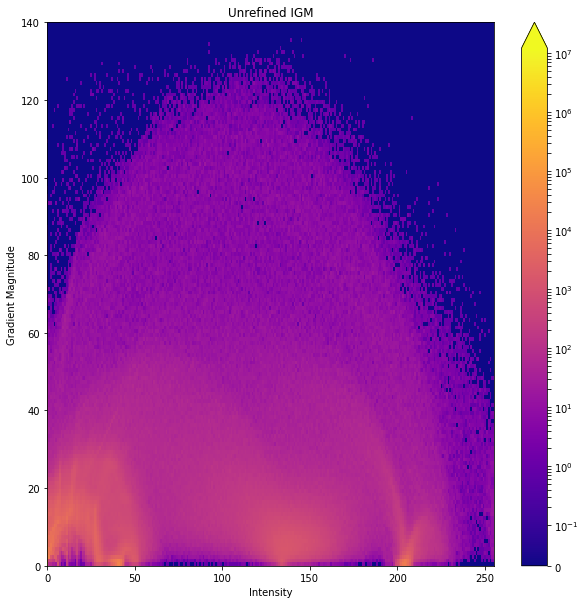

In [77]:
##Useful reference: https://matplotlib.org/3.1.1/tutorials/colors/colormapnorms.html

x = np.linspace(0, f_bins-1, f_bins)
y = np.linspace(0, g_bins-1, g_bins)
z = 1
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Intensity')
plt.ylabel('Gradient Magnitude')
plt.title('Unrefined IGM')
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, igm_bins_2d, 
               norm=colors.SymLogNorm(linthresh = 0.1, 
                                      vmin=igm_bins_2d.min(), 
                                      vmax=igm_bins_2d.max()), 
               cmap='plasma')
plt.colorbar(extend='max')
plt.show()


<ipython-input-78-3c5b41b495b9>:7: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh = 0.1,


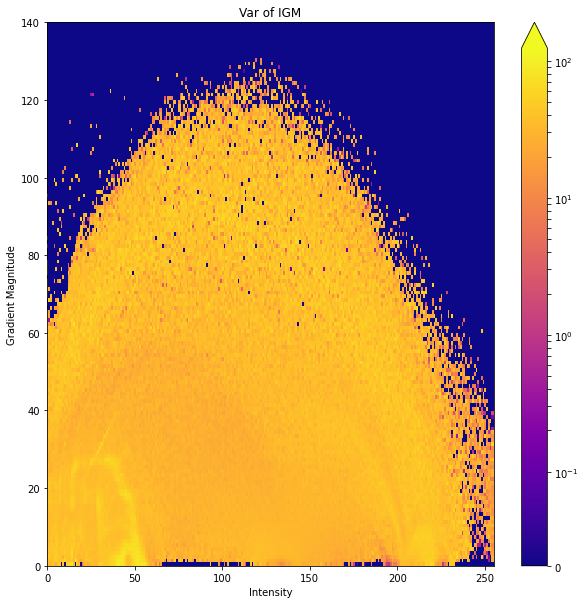

In [78]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Intensity')
plt.ylabel('Gradient Magnitude')
plt.title('Var of IGM')
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, var_2d, 
               norm=colors.SymLogNorm(linthresh = 0.1, 
                                      vmin=var_2d.min(), 
                                      vmax=var_2d.max()), 
               cmap='plasma')
plt.colorbar(extend='max')
plt.show()

<ipython-input-79-68068c723a82>:7: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh = 0.1,


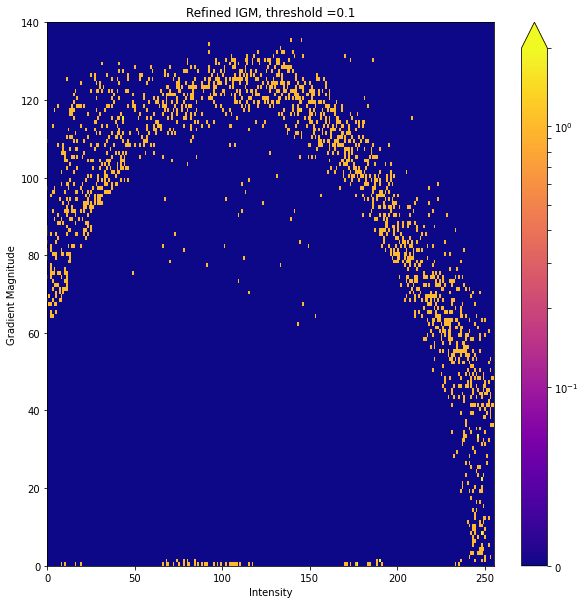

In [79]:

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Intensity')
plt.ylabel('Gradient Magnitude')
plt.title('Refined IGM, threshold =' + str(threshold))
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, igm_refined_2d, 
               norm=colors.SymLogNorm(linthresh = 0.1, 
                                      vmin=igm_refined_2d.min(), 
                                      vmax=igm_refined_2d.max()), 
               cmap='plasma')

plt.colorbar(extend='max')
plt.show()

In [80]:
#First, create our matrix of data - [intensity vs data]
cnt = -1
def gen_features_arr(igm_refined_2d, f_num_bins):
    features_arr = np.asarray([[x, y] for y, val in enumerate(igm_refined_2d)
                                                  for x, bins in enumerate(val)
                                                  if bins > 0 ])
    
    voxels_per_bin = np.full((igm_bins.shape[0], igm_bins.shape[0], 3), -1)
    igm_to_features_idx = np.zeros((igm_bins.shape[0]), dtype = np.int)

    
    def incr():
        global cnt
        cnt = cnt + 1
        return cnt
        
    igm_to_features_idx = np.asarray([incr() if bins > 0 else -1 for y, val in enumerate(igm_refined_2d)
                                                                            for x, bins in enumerate(val)])
    return features_arr, voxels_per_bin, igm_to_features_idx

    features_arr = []
    i= 0
    j = 0
    for y, val in enumerate(igm_refined_2d):
        for x, bins in enumerate(val):
            igm_to_features_idx[j] = -1
            if (bins > 0):
                features_arr.append([x, y])
                igm_to_features_idx[j] = i
                i = i + 1
            j = j + 1

            #voxels_per_bin.append(np.zeros([bins, 3], dtype=np.int))

    features_arr = np.asarray(features_arr)
    return features_arr, voxels_per_bin, igm_to_features_idx

features_arr, voxels_per_bin, igm_to_features_idx = gen_features_arr(igm_refined_2d, f_bins)
print(features_arr.shape)
print(voxels_per_bin.shape, igm_bins.shape)
test = 400
print(igm_to_features_idx[test])
print(features_arr[igm_to_features_idx[test]])
print(igm_refined[test])
print(igm_to_features_idx.max())
print(igm_to_features_idx.shape)

(1735, 2)
(36096, 36096, 3) (36096,)
-1
[190 140]
0
1734
(36096,)


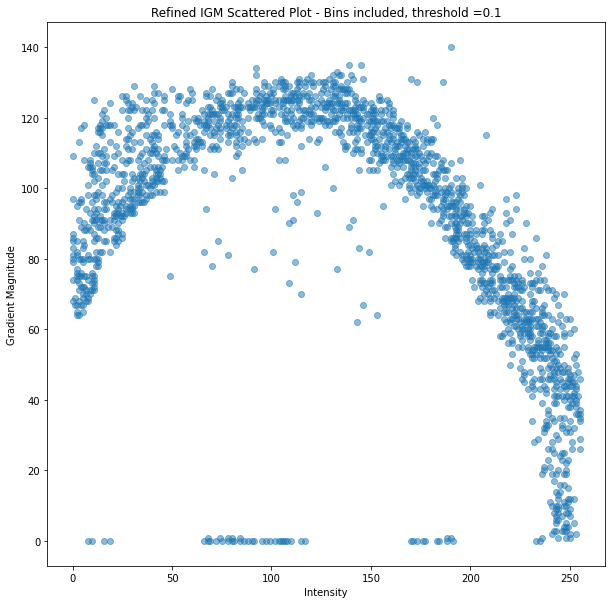

In [81]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Intensity')
plt.ylabel('Gradient Magnitude')
plt.title('Refined IGM Scattered Plot - Bins included, threshold =' + str(threshold))
#X, Y = np.meshgrid(x, y)
plt.scatter(features_arr[:, 0], features_arr[:, 1], alpha=0.5)
plt.show()

In [82]:
@cuda.jit
def setIGM_Matrix(row_arr, feature_arr, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y
    
    #if (i == 0):
    #    print(row_id)
    if (i >= num_bins or row_id >= num_bins):
        return
    
    #Do the similary between this thread and the row id
    bxi = feature_arr[row_id][0]
    bxg = feature_arr[row_id][1]
    
    byi = feature_arr[i][0]
    byg = feature_arr[i][1]
    
    row_arr[row_id][i] = math.sqrt(float(pow(bxi - byi,2) + pow(bxg - byg,2)))
    
    
@cuda.jit
def normalizeIGM_Matrix(row_arr, sIGM_min, sIGM_range, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y
    
    #if (i == 0):
    #    print(row_id)
    if (i >= num_bins or row_id >= num_bins):
        return
    
    
    row_arr[row_id][i] = (row_arr[row_id][i] - sIGM_min)/(sIGM_range)

def calcSIGM_Matrix(features_arr):
    sIGM_matrix = np.zeros([features_arr.shape[0], features_arr.shape[0]], dtype = np.float32)
    
    num_bins = features_arr.shape[0]
    
    #Figure out launch configuration
    #Launch a thread for every row
    blockSize = 256
    gridX = iDivUp(features_arr.shape[0], blockSize) #Numer of blocks for a row
    gridY = num_bins                #Create gridY gridX's for each row
    gridSize  = gridX, gridY
    
    print(gridX, gridY)
    
    start_time = timeit.default_timer()
 
    #Launch a 2D grid where each thread is working on a specific row and item
    setIGM_Matrix[gridSize, blockSize](sIGM_matrix, features_arr, num_bins)
       
    elapsed = timeit.default_timer() - start_time
    print("here", elapsed)
    
    start_time = timeit.default_timer()
    #now normalize the matrix
    sIGM_max = sIGM_matrix.max()
    sIGM_min = sIGM_matrix.min()
    sIGM_range = sIGM_max - sIGM_min
    
    normalizeIGM_Matrix[gridSize, blockSize](sIGM_matrix, sIGM_min, sIGM_range, num_bins)
    
    
    
    #sIGM_matrix = (sIGM_matrix - sIGM_min)/(sIGM_range)
    elapsed = timeit.default_timer() - start_time
    print("done", elapsed)
    
    return sIGM_matrix
        

In [83]:
@cuda.reduce
def sum_reduce(a, b):
    return a+b



@cuda.jit(device=True)
def getVoxelBin(data_ptr, grad_mag_ptr, i, j, k, f_bin_min, g_bin_min, f_bin_size, g_bin_size):
    if (i > 255 or i <0):
        print("i error!")
    if (j > 255 or j < 0):
        print("j error!")
    if (k > 255 or k < 0):
        print("k error!")
    
    f_val = data_ptr[i][j][k]     - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)   
    
    ##TODO check this if there's a problem
    loc   = f_loc + f_num_bins*g_loc
    
    return loc
    
    
    
#Two voxels are neighbours if any of their coordinates is one
#unit apart
@cuda.jit(device=True)
def isNeighbour(X, Y):
    dX = abs(X[0] - Y[0])
    dY = abs(X[1] - Y[1])
    dZ = abs(X[2] - Y[2])
    
    if (X[0] == -1 or Y[0] == -1):
        print("oops!")
        
    if (dX == 1 or dY == 1 or dZ == 1):
        if (dX <= 1 and dY <= 1 and dZ <= 1):
            return 1
    return 0


@cuda.jit
def normalizeSVOL_Matrix(sVOL_matrix, neigh_sums, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y    

    if (i >= num_bins or row_id >= num_bins):
        return
    
    bx = neigh_sums[row_id] 
    by = neigh_sums[i]
    
    if (bx == 0 or by == 0):
        sVOL_matrix[row_id][i] = 0
        return
    
    sVOL_matrix[row_id][i] = max(sVOL_matrix[row_id][i]/bx, sVOL_matrix[i][row_id]/by)
    
    
#Each thread represents a voxel 
#We first figure out which bin this voxel belongs to, this gives us the rowID of sVOL_matrix
#Then find all the neighbours of this voxel
#For each neighbour, check which bin it belongs to
#Atomically increment the neighbour count for rowID and that bin
@cuda.jit
def setSVol_Matrix(sVOL_matrix, data_ptr, grad_mag_ptr, igm_to_features_idx, 
                   features_arr,
                   num_bins, f_num_bins, f_bin_min, g_bin_min, f_bin_size, g_bin_size, data_size):
    
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    #Which bin do I belong to?
    loc   = getVoxelBin(data_ptr, grad_mag_ptr, i, j, k, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
    rowID = igm_to_features_idx[loc]
    
    #If rowID is -1, this voxel is not part of a bin
    if (rowID == -1):
        return
    #######################################
    #Find all the neighbours of this voxel
    #And increment neighbourhood count
    #######################################
    
    #001
    xn = i
    yn = j
    zn = k - 1
    
    if(zn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i
    yn = j
    zn = k + 1
 

    if(zn < z_size):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    #010
    xn = i
    yn = j - 1
    zn = k
    
    if(yn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i
    yn = j + 1
    zn = k
  
    if(yn < y_size):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)
    
   
    #100
    xn = i - 1
    yn = j
    zn = k
    
    if(xn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i + 1
    yn = j
    zn = k
    
    if(xn < x_size):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    #011
    xn = i
    yn = j - 1
    zn = k - 1 
    
    if(yn > 0 and zn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):      
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i
    yn = j + 1
    zn = k + 1
    
    if(yn < data_size[1] and zn < data_size[2]):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)
       
    #110
    xn = i - 1
    yn = j - 1
    zn = k
    
    if(yn > 0 and xn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i + 1
    yn = j + 1
    zn = k
    
 
    if(yn < y_size and xn < x_size):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]      
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):   
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)
        

    #101
    xn = i - 1
    yn = j
    zn = k - 1
    
    if(zn > 0 and xn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i + 1
    yn = j 
    zn = k + 1
    
    if(zn < z_size and xn < x_size):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)
 
            
@cuda.jit            
def setSVol_Matrix2(sVOL_matrix, data_ptr, grad_mag_ptr, igm_to_features_idx, 
                   features_arr,
                   num_bins, f_num_bins, f_bin_min, g_bin_min, f_bin_size, g_bin_size, data_size):
    
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    #Which bin do I belong to?
    loc   = getVoxelBin(data_ptr, grad_mag_ptr, i, j, k, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
    rowID = igm_to_features_idx[loc]
    
    #If rowID is -1, this voxel is not part of a bin
    if (rowID == -1):
        return
    #######################################
    #Find all the neighbours of this voxel
    #And increment neighbourhood count
    #######################################
    locn = 0
    colID = 0
    

    #111
    xn = i - 1
    yn = j - 1
    zn = k - 1
    
    if(zn > 0 and xn > 0 and yn > 0):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

    xn = i + 1
    yn = j + 1
    zn = k + 1
    
    if(zn < z_size and xn < x_size and yn < y_size):
        #Get the bin this neighbour belongs to
        locn = getVoxelBin(data_ptr, grad_mag_ptr, xn, yn, zn, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
        colID = igm_to_features_idx[locn]
        
        #If colID is -1, this voxel is not part of a bin
        if (colID != -1):        
            cuda.atomic.add(sVOL_matrix[rowID], colID, 1)

            
@cuda.jit
def populateVoxelsInBin(voxels_in_bin, igm_refined, data_ptr, grad_mag_ptr, 
                        data_bin_ptr, f_bin_min, g_bin_min,
                        f_num_bins, g_num_bins, data_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k]     - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)   
    
    ##TODO check this if there's a problem
    loc   = f_loc + f_num_bins*g_loc
       
    

    
    if (igm_refined[loc] > 0) :
        ##Is this voxel in a non-zero bin
        if (loc == 0):
            print(i, j, k, igm_refined[loc])
        pos = data_bin_ptr[i][j][k]
        voxels_in_bin[loc][pos][0] = i
        voxels_in_bin[loc][pos][1] = j
        voxels_in_bin[loc][pos][2] = k
    
##Now figure out the spatial similarity matrix
def calcSVOL_Matrix(features_arr, igm_refined, igm_to_features_idx, voxels_in_bin, igm_size, data_ptr, grad_mag_ptr, 
                    fval_min, gval_min, f_num_bins, g_num_bins, f_bin_size, g_bin_size, data_size):
    num_bins = features_arr.shape[0]
    sVOL_matrix = np.zeros([num_bins, num_bins], dtype = np.float32)
    
 
    ###########################################
    #Get the voxels each bin contains first
    ###########################################
    #Launch a thread per voxel
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    start_time = timeit.default_timer()
    
    #for i, bin_item in enumerate(features_arr):
    populateVoxelsInBin[gridSize, blockSize](voxels_in_bin, igm_refined, data_ptr, grad_mag_ptr, 
                          data_bin_ptr, fval_min, gval_min, f_num_bins, g_num_bins, data_size)
        
    cuda.synchronize()
    elapsed = timeit.default_timer() - start_time
    print("Time elapsed", elapsed)
    

    ###########################################
    #Set the matrix
    ###########################################    
    start_time = timeit.default_timer()
 
    #Launch a 2D grid where each thread is working on a specific row and voxel
    setSVol_Matrix[gridSize, blockSize](sVOL_matrix, data_ptr, grad_mag_ptr, igm_to_features_idx, 
                   features_arr, 
                   num_bins, f_num_bins, fval_min, gval_min, f_bin_size, g_bin_size, data_size)
    cuda.synchronize()

    #Launch a 2D grid where each thread is working on a specific row and voxel
    setSVol_Matrix2[gridSize, blockSize](sVOL_matrix, data_ptr, grad_mag_ptr, igm_to_features_idx, 
                   features_arr, 
                   num_bins, f_num_bins, fval_min, gval_min, f_bin_size, g_bin_size, data_size)
    cuda.synchronize()
    elapsed = timeit.default_timer() - start_time
    print("2. Time elapsed", elapsed)   
    
    

    ###########################################
    #Sum each row
    ###########################################    
    start_time = timeit.default_timer()

    ##Now setup the sVOL_matrix
    #Launch a thread for every row
    blockSize = 256
    gridX = iDivUp(features_arr.shape[0], blockSize) #Numer of blocks for a row
    gridY = num_bins                #Create gridY gridX's for each row
    gridSize  = gridX, gridY    
    
    print("svol before", sVOL_matrix)
    
    neigh_sums = np.asarray([sum_reduce(item) for item in sVOL_matrix])
    print(neigh_sums)
    
    ##Now get the normalized similarity matrix
    normalizeSVOL_Matrix[gridSize, blockSize](sVOL_matrix, neigh_sums, num_bins)
    print("3. Time elapsed", elapsed)   

    
    return sVOL_matrix, voxels_in_bin


In [84]:
sIGM_matrix = calcSIGM_Matrix(features_arr)
print(sIGM_matrix)
print(f_bin_size)
print(features_arr)

7 1735
here 0.21108290646225214
done 0.16481627151370049
[[0.         0.00728077 0.02912308 ... 0.68479896 0.7001853  0.8358946 ]
 [0.00728077 0.         0.02184231 ... 0.6797488  0.6950181  0.8301355 ]
 [0.02912308 0.02184231 0.         ... 0.66484636 0.6797488  0.81300485]
 ...
 [0.68479896 0.6797488  0.66484636 ... 0.         0.02184231 0.18654977]
 [0.7001853  0.6950181  0.6797488  ... 0.02184231 0.         0.16482545]
 [0.8358946  0.8301355  0.81300485 ... 0.18654977 0.16482545 0.        ]]
1
[[  8   0]
 [ 10   0]
 [ 16   0]
 ...
 [139 135]
 [145 135]
 [190 140]]


In [85]:
#cuda.get_current_device().reset()
sVOL_matrix, voxels_per_bin = calcSVOL_Matrix(features_arr, igm_refined, igm_to_features_idx, 
                                              voxels_per_bin, f_bins*g_bins, data_ptr, 
                                              grad_mag_ptr, fval_min, gval_min, f_bins, g_bins, f_bin_size, g_bin_size,
                                              data_size)
print(sVOL_matrix.shape)
print(voxels_per_bin[1])
print(igm_refined[1])

print(sVOL_matrix)

Time elapsed 6.9057252472266555
2. Time elapsed 1.668362084776163
svol before [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[3. 1. 0. ... 0. 0. 0.]
3. Time elapsed 1.668362084776163
(1735, 1735)
[[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 ...
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [86]:
print(np.unique(sVOL_matrix))

[0.00000000e+00 7.99762478e-09 8.94267487e-08 1.38408302e-06
 8.94294426e-05 2.52016122e-04 2.99043051e-04 6.83526974e-04
 6.84931525e-04 6.98812015e-04 7.56048365e-04 8.76424194e-04
 8.97129183e-04 9.24214430e-04 9.26784065e-04 1.01936795e-03
 1.02145050e-03 1.15207373e-03 1.17647054e-03 1.19617220e-03
 1.23609393e-03 1.26008061e-03 1.36705395e-03 1.39762403e-03
 1.47928996e-03 1.49521534e-03 1.49700604e-03 1.51209673e-03
 1.79425837e-03 1.80180185e-03 1.84842886e-03 1.85356813e-03
 2.02020211e-03 2.03873590e-03 2.04918021e-03 2.05058092e-03
 2.09330139e-03 2.09643599e-03 2.18499638e-03 2.29357788e-03
 2.30414746e-03 2.39234441e-03 2.44798046e-03 2.62927264e-03
 2.69138766e-03 2.69360258e-03 2.72386800e-03 2.73410790e-03
 2.73972610e-03 2.77217734e-03 2.77264323e-03 2.79524806e-03
 2.89855083e-03 2.99043069e-03 2.99401209e-03 3.05810408e-03
 3.15315323e-03 3.28947371e-03 3.36700329e-03 3.41763510e-03
 3.45622119e-03 3.49406013e-03 3.62318847e-03 3.65296798e-03
 3.69685772e-03 3.707136

In [87]:
print(np.count_nonzero(sVOL_matrix))
print(sVOL_matrix.size)

14930
3010225


In [88]:
@cuda.jit
def populateSimilarityMatrix(sIGM_matrix, sVOL_matrix, k1, k2, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y    

    if (i >= num_bins or row_id >= num_bins):
        return   

    sIGM_matrix[row_id][i] = k1*sIGM_matrix[row_id][i] + k2*sVOL_matrix[row_id][i]

def setSimilarityMatrix(sIGM_matrix, sVOL_matrix, k1 = -0.35, k2 = 0.65):
    start_time = timeit.default_timer()
    #similarityMatrix = k1*sIGM_matrix + k2*sVOL_matrix   
    
    num_bins = sIGM_matrix.shape[0]
    
    ##Now setup the sVOL_matrix
    #Launch a thread for every row
    blockSize = 256
    gridX = iDivUp(features_arr.shape[0], blockSize) #Numer of blocks for a row
    gridY = num_bins                #Create gridY gridX's for each row
    gridSize  = gridX, gridY    
    
    start_time = timeit.default_timer()
 
    #Launch a 2D grid where each thread is working on a specific row and item
    populateSimilarityMatrix[gridSize, blockSize](sIGM_matrix, sVOL_matrix, k1, k2, num_bins)
       
    elapsed = timeit.default_timer() - start_time
    
    print("Time elapsed", elapsed)   
    return sIGM_matrix


In [109]:
similarityMatrix = setSimilarityMatrix(sIGM_matrix, sVOL_matrix, k1 = 0.1, k2 = 0.9)
print(similarityMatrix)

Time elapsed 0.09879754390567541
[[0.         0.00011649 0.00046597 ... 0.01095678 0.01120296 0.01337431]
 [0.00011649 0.         0.00034948 ... 0.01087598 0.01112029 0.01328217]
 [0.00046597 0.00034948 0.         ... 0.01063754 0.01087598 0.01300808]
 ...
 [0.01095678 0.01087598 0.01063754 ... 0.         0.00034948 0.0029848 ]
 [0.01120296 0.01112029 0.01087598 ... 0.00034948 0.         0.00263721]
 [0.01337431 0.01328217 0.01300808 ... 0.0029848  0.00263721 0.        ]]


In [110]:
##Time to do some AP clustering!
#First, let's do the automatic AP clustering method. Later I'll implement the one in the paper
start_time = timeit.default_timer()
af = AffinityPropagation(affinity="precomputed", verbose="True").fit(similarityMatrix)
cluster_centers_indices = af.cluster_centers_indices_ 
labels = af.labels_ 
  
n_clusters_ = len(cluster_centers_indices) 
elapsed = timeit.default_timer() - start_time
print("Time elapsed", elapsed)   

print(labels, n_clusters_)


/home/toodemuy/miniconda3/envs/voronoi_2020/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


Converged after 61 iterations.
Time elapsed 3.294015438295901
[ 0  1 28 ...  0  0  0] 191


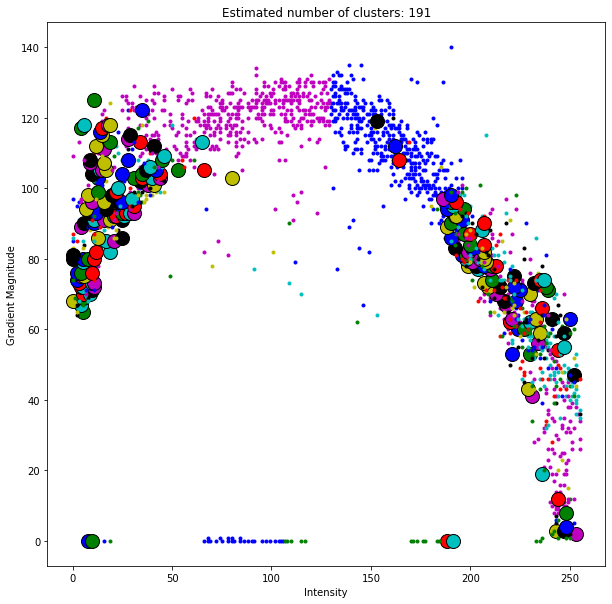

In [111]:
##Plot the AP results on our original histogram
#Modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py 
import matplotlib.pyplot as plt
from itertools import cycle

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Intensity')
plt.ylabel('Gradient Magnitude')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = features_arr[cluster_centers_indices[k]]
    plt.plot(features_arr[class_members, 0], features_arr[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    #for x in features_arr[class_members]:
    #    plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, "o")
  

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('Intensity')
plt.ylabel('Gradient Magnitude')
plt.show()

In [112]:
##Now we're going to ray cast it
class_members = labels == k
print(class_members.shape)
print(labels)
print(labels.shape)

(1735,)
[ 0  1 28 ...  0  0  0]
(1735,)


In [113]:
voxel_to_cluster = np.zeros(volumeInfo['size'], dtype = np.int) #voxel to cluster label
cluster_alphas   = np.zeros(n_clusters_, dtype = np.float32)    #alpha value for a cluster
cluster_grad_max = np.zeros(n_clusters_, dtype = np.float32)
 
@cuda.jit
def assignVoxelTF(data_ptr, grad_mag_ptr, f_bin_min, g_bin_min, f_bin_size, g_bin_size, data_size,
                  labels, igm_to_features_idx, cluster_cnt, cluster_alph, voxel_to_cluster, d_center, cluster_grad_max):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
        
    
    #Find the cluster I'm in
    locn = getVoxelBin(data_ptr, grad_mag_ptr, i, j, k, f_bin_min, g_bin_min, f_bin_size, g_bin_size)
    colID = igm_to_features_idx[locn]       
    cluster = labels[colID]
                                                              
    #calculate distance from the center
    x_dist = math.pow(i - d_center[0], 2)
    y_dist = math.pow(j - d_center[1], 2)
    z_dist = math.pow(k - d_center[2], 2)

    this_dist = math.sqrt(float(x_dist + y_dist + z_dist))
    
    
    #update voxel to cluster array
    voxel_to_cluster[i][j][k] = cluster
    
    #update distance count for this cluster
    cuda.atomic.add(cluster_alph, cluster, this_dist)
    #update voxel count for this cluster
    cuda.atomic.add(cluster_cnt, cluster, 1)
    cuda.atomic.max(cluster_grad_max, cluster, grad_mag_ptr[i][j][k])


def clusterToTF(data_ptr, grad_mag_ptr, f_bin_min, g_bin_min, f_bin_size, g_bin_size, 
                data_size, labels, igm_to_features_idx, cluster_alphas, voxel_to_cluster, cluster_grad_max):
    d_center = np.asarray([0, 0, 0])
    d_center[0] = data_size[0]//2
    d_center[1] = data_size[1]//2
    d_center[2] = data_size[2]//2
    
    cluster_cnt = np.zeros(n_clusters_, dtype=np.int)
    
    
    #Launch a thread for each voxel
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    start_time = timeit.default_timer()

    assignVoxelTF[gridSize, blockSize](data_ptr, grad_mag_ptr, f_bin_min, g_bin_min, f_bin_size, g_bin_size, 
                                    data_size, labels, igm_to_features_idx, cluster_cnt, 
                                    cluster_alphas, voxel_to_cluster, d_center, cluster_grad_max)
    
    cuda.synchronize()
    elapsed = timeit.default_timer() - start_time
    print("Time elapsed", elapsed) 
    print(cluster_cnt)
    
    #assign TFs to each voxel
    cluster_alphas = cluster_alphas/cluster_cnt
    
    max_d = cluster_alphas.max()
    min_d = cluster_alphas.min()
    print(max_d, min_d)
    print("current", cluster_alphas)
    cluster_alphas = (cluster_alphas - min_d)/(max_d - min_d)
    cluster_alphas = cluster_alphas*(1 - 0.2) + 0.2
    
    return cluster_alphas, cluster_grad_max

In [114]:
cluster_alphas, cluster_grad_max = clusterToTF(data_ptr, grad_mag_ptr, fval_min, gval_min, f_bin_size, g_bin_size, 
                data_size, labels, igm_to_features_idx, cluster_alphas, voxel_to_cluster, cluster_grad_max)
print("cluster_alphas", cluster_alphas)
print(voxel_to_cluster[3][0])
print(cluster_grad_max)

Time elapsed 0.6303633162751794
[16538939     3750        8        5   210181        4       12        5
     3542     3723     4398       44       48       52       45       42
       88       98       86       79      167       62       39       36
      102       41       21       39      186      109      111      183
       22     2991       21       28      175      148      161      875
       94       44       23      104      111      220       40       30
       19       49       83      216       46       25       28       31
      111       12       38       23      276      990       30       99
       61      142       20       25       15       32       36       22
       47       60       22       25       39       97       37       41
       12       34       27       55       19       25       46       17
       16       25        6       10       14       34       22       32
       33       25       21        8       20       27       52        3
       43       35 

In [115]:
import colorsys
from PIL import Image

##Now render
##This is a CUDA device function
@cuda.jit(device=True)
def getBoundsX(index):
    bounds = 0
    
    bounds = int(math.floor(index))        
    return bounds

##This is a CUDA device function
@cuda.jit(device=True)
def getBoundsY(index):
    bounds = 0
    upper  = int(math.ceil(index))
        
    if (math.ceil(index) == index):
        bounds = upper + 1
    else:
        bounds = int(math.ceil(index))
    return bounds

@cuda.jit(device=True)
def sampleVoxel(u, v, varPos, data_ptr, gval_arr, proj_plane, data_size, gval, vol, rel):
    fval = 0
    
    #Map u, v, varPos to x, y, z depending on projection

    x = 0
    y = 0
    z = 0
    
    if (proj_plane == 0):
        x = u
        y = v
        z = varPos
    elif (proj_plane == 1):
        x = u
        y = varPos
        z = v
    elif(proj_plane == 2):
        x = varPos
        y = u
        z = v
        
    ############################################
    #Find which voxel this sample point is in
    ############################################      
    x_l = getBoundsX(x)
    x_h = getBoundsY(x)
    
    y_l = getBoundsX(y)
    y_h = getBoundsY(y)
    
    z_l = getBoundsX(z)
    z_h = getBoundsY(z)
    
    vol[0] = min(x_l, x_h)
    vol[1] = min(y_l, y_h)
    vol[2] = min(z_l, z_h)
    
    #Boundary check
    if (vol[0] == (data_size[0] - 1)):
        vol[0] = vol[0] - 1
    if (vol[1] == (data_size[1] - 1)):
        vol[1] = vol[1] - 1
    if (vol[2] == (data_size[2] - 1)):
        vol[2] = vol[2] - 1
    
    
    #Get the relative position with this voxel
    rel[0] = x - vol[0]
    rel[1] = y - vol[1]
    rel[2] = z - vol[2]
    
    #Set voxel values
    if ((vol[0] + 1) > 255 or vol[0] < 0):
        print("X error")

    if ((vol[1] + 1) > 255 or vol[1] < 0):
        print("Y error")
        
    if ((vol[2] + 1)> 255 or vol[2] < 0):
        print("Z error")
        
    f000 = data_ptr[vol[0]][vol[1]][vol[2]]
    f001 = data_ptr[vol[0]+1][vol[1]][vol[2]]
    f010 = data_ptr[vol[0]][vol[1]+1][vol[2]]
    f011 = data_ptr[vol[0]+1][vol[1]+1][vol[2]]
    f100 = data_ptr[vol[0]][vol[1]][vol[2]+1]
    f101 = data_ptr[vol[0]+1][vol[1]][vol[2]+1]
    f110 = data_ptr[vol[0]][vol[1]+1][vol[2]+1]
    f111 = data_ptr[vol[0]+1][vol[1]+1][vol[2]+1]   

    '''
    g000 = grad_ptr[vol[0]][vol[1]][vol[2]]
    g001 = grad_ptr[vol[0]+1][vol[1]][vol[2]]
    g010 = grad_ptr[vol[0]][vol[1]+1][vol[2]]
    g011 = grad_ptr[vol[0]+1][vol[1]+1][vol[2]]
    g100 = grad_ptr[vol[0]][vol[1]][vol[2]+1]
    g101 = grad_ptr[vol[0]+1][vol[1]][vol[2]+1]
    g110 = grad_ptr[vol[0]][vol[1]+1][vol[2]+1]
    g111 = grad_ptr[vol[0]+1][vol[1]+1][vol[2]+1]    
    '''
     
    #Perform Trilinear interpolation
    fval = ((1-rel[2]) * (1-rel[1])  * (1-rel[0])   * f000 +
             (1-rel[2]) * (1-rel[1])  * (rel[0])    * f001 + 
             (1-rel[2]) * (rel[1])    * (1-rel[0])  * f010 +
             (1-rel[2]) * (rel[1])    * (rel[0])    * f011 +
             (rel[2])   * (1-rel[1])  * (1-rel[0])  * f100 +
             (rel[2])   * (1-rel[1])  * (rel[0])    * f101 +
             (rel[2])   * (rel[1])    * (1-rel[0])  * f110 +
             (rel[2])   * (rel[1])    * (rel[0])    * f111)

    gval[0] = ((1-rel[2]) * (1-rel[1]) * (-1) * f000 +
               (1-rel[2]) * (1-rel[1]) * f001        +
               (1-rel[2]) * (rel[1])   * (-1) * f010 +
               (1-rel[2]) * (rel[1])   * f011        +
               (rel[2])   * (1-rel[1]) * (-1) * f100 +
               (rel[2])   * (1-rel[1]) * f101        +
               (rel[2])   * (rel[1])   * (-1) * f110 +
               (rel[2])   * (rel[1])   * f111 )

    gval[1] = ((1-rel[2]) * (-1)       * (1-rel[0])  * f000 +
               (1-rel[2]) * (-1)       * (rel[0])    * f001 +
               (1-rel[2]) * (1-rel[0])  * f010 +
               (1-rel[2]) * (rel[0])    * f011 +
               (rel[2])   * (-1)       * (1-rel[0])  * f100 +
               (rel[2])   * (-1)       * (rel[0])    * f101 +
               (rel[2])   * (1-rel[0])  * f110 +
               (rel[2])   * (rel[0])    * f111)

    gval[2] = ((-1) * (1-rel[1]) * (1-rel[0]) * f000 +
               (-1) * (1-rel[1])  * (rel[0])    * f001 +
               (-1) * (rel[1])    * (1-rel[0])  * f010 +
               (-1) * (rel[1])    * (rel[0])    * f011 +
               (1-rel[1])  * (1-rel[0])  * f100 +
               (1-rel[1])  * (rel[0])    * f101 +
               (rel[1])    * (1-rel[0])  * f110 +
               (rel[1])    * (rel[0])    * f111)
    return fval

greyscale = 0

#Generate the transfer function from this
@cuda.jit(device=True)
def rgbaTF(f_val, gval, vol, temp_RGBA, voxel_to_cluster, num_clusters, 
           grad_mag_ptr, clusters_to_alphas, cluster_grad_max):
    global greyscale
    #which cluster does this belong to
    cluster = voxel_to_cluster[vol[0]][vol[1]][vol[2]]
    grad_max = cluster_grad_max[cluster]
    
    #Find the opacity
    my_grad = math.sqrt(pow(gval[0],2) + pow(gval[1], 2) + pow(gval[2], 2))/(grad_max)
    if (my_grad > 1 or my_grad < 0.2):
    #    print("Greater", my_grad)
        my_grad = grad_mag_ptr[vol[0]][vol[1]][vol[2]]
    
    #my_grad = grad_mag_ptr[vol[0]][vol[1]][vol[2]]        
    grad_max = cluster_grad_max[cluster]
    alpha = clusters_to_alphas[cluster]
    alpha = alpha * pow(my_grad/grad_max, 3)
    
    S = 1
    V = 1
    H = (cluster * 360)/(num_clusters-1)
    
    #HSV to RGB copied from: http://code.activestate.com/recipes/576919-python-rgb-and-hsv-conversion/
    h = float(H)
    s = float(S)
    v = float(V)
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    #r, g, b = int(r * 255), int(g * 255), int(b * 255)
    
    #Use Phong's model
    dotP = (gval[0]/grad_max)*1 + (gval[1]/grad_max)*1 + (gval[2]/grad_max)*1

 
    if greyscale:
        temp_RGBA[0] =  0.2 * dotP
        temp_RGBA[1] =  0.2 * dotP
        temp_RGBA[2] =  0.2 * dotP
    else:
        temp_RGBA[0] =  r * dotP
        temp_RGBA[1] =  g * dotP
        temp_RGBA[2] =  b * dotP
        
    temp_RGBA[3] = alpha
         
        
##Set coordinates for the mesh
##Returns the coordinates that the grid mesh will be evaluated on
def setGridMesh(pheight, pwidth, x_lim, y_lim):
    x_steps = x_lim/pwidth
    y_steps = y_lim/pheight
    print("xsteps is %f, ysteps is %f" % (x_steps, y_steps))
    return (x_steps, y_steps)

@cuda.jit
def rayCastPixel(pixelArray, fval_arr, gval_arr, height, width, step, max_steps,
                 d_size_u, d_size_v, data_size, proj_plane, g_arr, vol_arr, rel_arr,
                 finalPixel_arr, tempRGBA_arr, curRGBA_arr, voxel_to_cluster, num_clusters, 
                 grad_mag_mtr, clusters_to_alphas,
                 cluster_grad_max): 
    pixelX = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    pixelY = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y

    OP_THRESHOLD = 0.95
    
    ##Make sure we're  not out of bounds
    if ((pixelX >= width) or (pixelY >= height)):
        return   
    
    
    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]
    
    levoyK = 0.95
    
    u = d_size_u/width * pixelX
    v = d_size_v/height * pixelY
    
    finalPixel = finalPixel_arr[pixelX][pixelY]
    temp_RGBA   = tempRGBA_arr[pixelX][pixelY]
    cur_RGBA    = curRGBA_arr[pixelX][pixelY]
    
    gval = g_arr[pixelX][pixelY]
    vol  = vol_arr[pixelX][pixelY]
    rel  = rel_arr[pixelX][pixelY]
    
    #Direction we're raycasting through
    varPos = 0
    
    for i in range(max_steps):
        
        f_val = sampleVoxel(u, v, varPos, fval_arr, gval_arr, proj_plane, data_size, gval, vol, rel)
            
        rgbaTF(f_val, gval, vol, temp_RGBA, voxel_to_cluster, num_clusters, grad_mag_mtr, clusters_to_alphas,
              cluster_grad_max)
        cur_RGBA = temp_RGBA
           
        #alpha times sampled colour
        cur_RGBA[0] = cur_RGBA[0] * cur_RGBA[3]
        cur_RGBA[1] = cur_RGBA[1] * cur_RGBA[3]
        cur_RGBA[2] = cur_RGBA[2] * cur_RGBA[3]
        
        #update RGBA
        finalPixel[0] = finalPixel[0] + (cur_RGBA[0])*(1 - finalPixel[3])
        finalPixel[1] = finalPixel[1] + (cur_RGBA[1])*(1- finalPixel[3])
        finalPixel[2] = finalPixel[2] + (cur_RGBA[2])*(1- finalPixel[3])
        finalPixel[3] = finalPixel[3] + (cur_RGBA[3])*(1- finalPixel[3])
        
        if (finalPixel[3] > (0.95)):
            break
            
        #Let's step to the next spot, depth-wise    
        varPos = varPos + step

    pixelArray[pixelX][pixelY][0] = int(255 * finalPixel[0])
    pixelArray[pixelX][pixelY][1] = int(255 * finalPixel[1])
    pixelArray[pixelX][pixelY][2] = int(255 * finalPixel[2])
    pixelArray[pixelX][pixelY][3] = int(255 * finalPixel[3])
    
    #print(pixelArray[pixelX][pixelY][0], temp_RGBA[0], 255* finalPixel[0])
    
def renderData(pixelArray, fval_arr, gval_arr, height, width, step, 
               max_steps, d_size_u, d_size_v, data_size, proj_plane, 
               voxel_to_cluster, num_clusters, 
                                      grad_mag_mtr, clusters_to_alphas,
                                      cluster_grad_max):
 
    #Figure out launch configuration
    blockSize = 16, 16
    gridSize  = iDivUp(width, 16), iDivUp(height, 16)
    
    gval = np.zeros([width, height, 3], dtype = np.float32)
    vol  = np.zeros([width, height, 3], dtype = np.int)
    rel  = np.zeros([width, height, 3], dtype = np.float32)
    finalPixel  = np.zeros([width, height, 4], dtype = np.float32)
    tempRGBA    = np.zeros([width, height, 4], dtype = np.float32)
    curRGBA     = np.zeros([width, height, 4], dtype = np.float32)
    
    print("fval is", fval_arr[0][0][0])
    
    print(gridSize, blockSize)
    rayCastPixel[gridSize, blockSize](pixelArray, fval_arr, gval_arr, 
                                      height, width, step, max_steps,
                                      d_size_u, d_size_v, data_size, proj_plane, gval, vol, rel, 
                                      finalPixel, tempRGBA, curRGBA, voxel_to_cluster, num_clusters, 
                                      grad_mag_mtr, clusters_to_alphas,
                                      cluster_grad_max)
    cuda.synchronize()
    print(pixelArray)


def displayImage(pixelArray, name):
    img = Image.fromarray(pixelArray, 'RGBA')
    img.save(name)
    imgplot = plt.imshow(img)
    plt.show()

step and max steps 0.1 2560.0
fval is 40
(160, 160) (16, 16)
[[[233   0   0 171]
  [233   0   0 171]
  [234   0   0 172]
  ...
  [  5   0   0 221]
  [  0   0   0 221]
  [255   0   0 225]]

 [[234   0   0 172]
  [234   0   0 172]
  [234   0   0 172]
  ...
  [  1   0   0 218]
  [254   0   0 221]
  [251   0   0 225]]

 [[234   0   0 173]
  [234   0   0 173]
  [234   0   0 173]
  ...
  [254   0   0 219]
  [250   0   0 221]
  [247   0   0 225]]

 ...

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]]


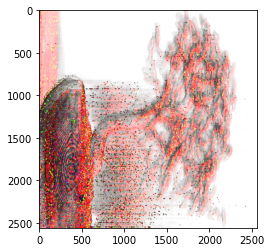

In [116]:
proj_plane = 0

if (proj_plane == 0):
    d_size_u = data_size[0]
    d_size_v = data_size[1]
    depth    = data_size[2]
    
if (proj_plane == 1):
    d_size_u = data_size[0]
    d_size_v = data_size[2]
    depth    = data_size[1]

    
if (proj_plane == 2):
    d_size_u = data_size[1]
    d_size_v = data_size[2]
    depth    = data_size[0]


width =  d_size_u*10
height = d_size_v*10
step = 0.1
max_steps = (depth/step)
print("step and max steps", step, max_steps)

pixelArray = np.zeros([width, height, 4], dtype = np.uint8)

renderData(pixelArray, data_ptr, grad_ptr, height, width, step,
               max_steps, d_size_u, d_size_v, data_size, proj_plane,
               voxel_to_cluster, n_clusters_, 
                                      grad_mag_ptr, cluster_alphas,
                                      cluster_grad_max)
pixelArray = pixelArray.transpose(1, 0, 2)

displayImage(pixelArray, "./bonsai.png")
